In [65]:
import requests
import json
import time
import re
import pprint as pp
import web3
import sys
from functools import lru_cache
from web3 import Web3
from web3.auto import w3
from web3.contract import Contract
from web3._utils.events import get_event_data
from web3._utils.abi import exclude_indexed_event_inputs, get_abi_input_names, get_indexed_event_inputs, normalize_event_input_types
from web3.exceptions import MismatchedABI, LogTopicError
from web3.types import ABIEvent
from eth_utils import event_abi_to_log_topic, to_hex
from hexbytes import HexBytes
from pyspark.sql.types import *
from pyspark.sql.functions import udf
from pyspark.sql.functions import *

from graphframes import GraphFrame
from graphframes.examples import Graphs
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))



## Get data via BigQuery connector

In [76]:
spark.conf.set("viewsEnabled","true")
spark.conf.set("materializationDataset","<dataset>")

eth_tx = spark.read.format("bigquery")\
    .option('table', 'bigquery-public-data:crypto_ethereum.transactions') \
    .load()

eth_tx.createOrReplaceTempView('eth_tx')
sql_hash = """
select hash, from_address, to_address, block_timestamp as ts, input from eth_tx
where to_address = lower('0x7be8076f4ea4a4ad08075c2508e481d6c946d12b')
    and DATE(block_timestamp) BETWEEN DATE_ADD(CURRENT_DATE(), -180) AND CURRENT_DATE()
"""

df_tx_0 = spark.sql(sql_hash)
df_tx = df_tx_0.withColumn("date",to_date("ts")).drop('ts')
df_tx.show(10)

# df_tx.groupBy('date').count().show()

+--------------------+--------------------+--------------------+--------------------+----------+
|                hash|        from_address|          to_address|               input|      date|
+--------------------+--------------------+--------------------+--------------------+----------+
|0x1a58c21faf3b40f...|0xcc1130ef1316786...|0x7be8076f4ea4a4a...|0xa8a41c700000000...|2021-09-13|
|0xcd7426a598360ef...|0x15bc91fcce42e10...|0x7be8076f4ea4a4a...|0xab834bab0000000...|2021-09-13|
|0x77c20308ba99433...|0x445d2fcfa5f47d8...|0x7be8076f4ea4a4a...|0xab834bab0000000...|2021-09-13|
|0x08f3d0a6ac3360e...|0xbe1bc27994b4e3d...|0x7be8076f4ea4a4a...|0xa8a41c700000000...|2021-09-13|
|0x8901305be2cb878...|0x985ef98d6cdadcb...|0x7be8076f4ea4a4a...|0xa8a41c700000000...|2021-09-13|
|0x181b90e108f48f3...|0x4dd361e4df81b42...|0x7be8076f4ea4a4a...|0xab834bab0000000...|2021-09-13|
|0x994d06c2f8b8352...|0x2b9cd3d309ec183...|0x7be8076f4ea4a4a...|0xab834bab0000000...|2021-09-13|
|0x2ae715914c7a1d7...|0x5193ef

In [77]:
eth_logs = spark.read.format("bigquery")\
    .option('table', 'bigquery-public-data:crypto_ethereum.logs') \
    .load()
eth_logs.createOrReplaceTempView('eth_logs')

sql_logs = """
SELECT transaction_hash, address, data, topics, block_timestamp as ts FROM eth_logs 
WHERE DATE(block_timestamp) BETWEEN DATE_ADD(CURRENT_DATE(), -180) AND CURRENT_DATE()
"""

df_logs_0 = spark.sql(sql_logs)
df_logs = df_logs_0.withColumn("date",to_date("ts")).drop('ts')
df_logs.show(10)

# df_logs.groupBy('date').count().show()

+--------------------+--------------------+--------------------+--------------------+----------+
|    transaction_hash|             address|                data|              topics|      date|
+--------------------+--------------------+--------------------+--------------------+----------+
|0xf3f581afacb712a...|0xd51b4c6bef34957...|0x000000000000000...|[0x1c411e9a96e071...|2021-08-12|
|0x452d1c8632f50e4...|0x9759226b2f8ddef...|                  0x|[0xddf252ad1be2c8...|2021-08-12|
|0x0912cd430afd4f8...|0xe75479ba035175a...|0x000000000000000...|[0x08fb6303c7942b...|2021-08-12|
|0xf54b8916a807dbd...|0xcc8fa225d80b9c7...|0x000000000000000...|[0xddf252ad1be2c8...|2021-08-12|
|0x24ca5408d418493...|0x7be8076f4ea4a4a...|0x000000000000000...|[0xc4109843e0b7d5...|2021-08-12|
|0xd074aa0e53e204d...|0xc02aaa39b223fe8...|0x000000000000000...|[0xe1fffcc4923d04...|2021-08-12|
|0x58917a4ec7b0269...|0xa2b4c0af19cc16a...|0x000000000000000...|[0xddf252ad1be2c8...|2021-08-12|
|0x3aa2beb96e341b6...|0xa0b869

In [79]:
df_join = df_tx.join(df_logs, df_tx.hash == df_logs.transaction_hash, 'inner')
df_join.count()

26435808

In [50]:

def decode_tuple(t, target_field):
    output = dict()
    for i in range(len(t)):
        if isinstance(t[i], (bytes, bytearray)):
            output[target_field[i]['name']] = to_hex(t[i])
        elif isinstance(t[i], (tuple)):
            output[target_field[i]['name']] = decode_tuple(t[i], target_field[i]['components'])
        else:
            output[target_field[i]['name']] = t[i]
    return output


def decode_list_tuple(l, target_field):
    output = l
    for i in range(len(l)):
        output[i] = decode_tuple(l[i], target_field)
    return output


def decode_list(l):
    output = l
    for i in range(len(l)):
        if isinstance(l[i], (bytes, bytearray)):
            output[i] = to_hex(l[i])
        else:
            output[i] = l[i]
    return output


def convert_to_hex(arg, target_schema):
    output = dict()
    for k in arg:
        if isinstance(arg[k], (bytes, bytearray)):
            output[k] = to_hex(arg[k])
        elif isinstance(arg[k], (list)) and len(arg[k]) > 0:
            target = [a for a in target_schema if 'name' in a and a['name'] == k][0]
            if target['type'] == 'tuple[]':
                target_field = target['components']
                output[k] = decode_list_tuple(arg[k], target_field)
            else:
                output[k] = decode_list(arg[k])
        elif isinstance(arg[k], (tuple)):
            target_field = [a['components'] for a in target_schema if 'name' in a and a['name'] == k][0]
            output[k] = decode_tuple(arg[k], target_field)
        else:
            output[k] = arg[k]
    return output

# @lru_cache(maxsize=None)
def _get_contract(address, abi):
    """
    This helps speed up execution of decoding across a large dataset by caching the contract object
    It assumes that we are decoding a small set, on the order of thousands, of target smart contracts
    """
    if isinstance(abi, (str)):
        abi = json.loads(abi)

    contract = w3.eth.contract(address=Web3.toChecksumAddress(address), abi=abi)
    return (contract, abi)

@udf
def decode_tx(address, input_data, abi):
    if abi is not None:
        try:
            (contract, abi) = _get_contract(address, abi)
            func_obj, func_params = contract.decode_function_input(input_data)
            target_schema = [a['inputs'] for a in abi if 'name' in a and a['name'] == func_obj.fn_name][0]
            decoded_func_params = convert_to_hex(func_params, target_schema)
            return func_obj.fn_name # json.dumps(decoded_func_params), json.dumps(target_schema))
        except:
            e = sys.exc_info()[0]
            return ('decode error', repr(e), None)
    else:
        return ('no matching abi', None, None)


## Get ABI for OpenSea NFT contracts

In [60]:
TX_HASH = '0x56f2ce34e4b20578742ed8ddc9fcbacaec62d477a530dff7ace8da2fe64b1208'
OPENSEA_CONTRACT_ADDR = "0x7be8076f4ea4a4ad08075c2508e481d6c946d12b"
BORED_APE_ADDR = "0xBC4CA0EdA7647A8aB7C2061c2E118A18a936f13D".lower()

def fetch_abi(contract_addr):
    ABI_ENDPOINT = 'https://api.etherscan.io/api?module=contract&action=getabi&address='
    response = requests.get('%s%s'%(ABI_ENDPOINT, contract_addr))
    response_json = response.json()
    abi_json = json.loads(response_json['result'])
    return json.dumps(abi_json)

opensea_abi = fetch_abi(OPENSEA_CONTRACT_ADDR)
time.sleep(5)
nft_abi = fetch_abi(BORED_APE_ADDR)
# pp.pprint(nft_abi)


## Decoding OpenSea Tx
. addrs[4] seems to be the address of the collection

TODO:
separate bidding and directly purchase


In [52]:
df_tx.show()

+--------------------+--------------------+--------------------+--------------------+----------+
|                hash|        from_address|          to_address|               input|      date|
+--------------------+--------------------+--------------------+--------------------+----------+
|0xc7a7ef3b188b231...|0x5eee571bcd194e8...|0x7be8076f4ea4a4a...|0xab834bab0000000...|2022-01-19|
|0xece74f0d5c77fff...|0xb0b0c2078cab6ef...|0x7be8076f4ea4a4a...|0xab834bab0000000...|2022-01-19|
|0xa539f865ab88447...|0x92b4ddebc6936b3...|0x7be8076f4ea4a4a...|0xab834bab0000000...|2022-01-19|
|0x90f06898d693c3b...|0xb1179f5243257e2...|0x7be8076f4ea4a4a...|0xab834bab0000000...|2022-01-19|
|0xb87d9ea79836efc...|0x86e046d016cca59...|0x7be8076f4ea4a4a...|0xab834bab0000000...|2022-01-19|
|0x7de04a91f94e7b9...|0x1d417fd6c173ed5...|0x7be8076f4ea4a4a...|0xab834bab0000000...|2022-01-19|
|0x735672f02e1cb9a...|0x4f25258def83182...|0x7be8076f4ea4a4a...|0xab834bab0000000...|2022-01-19|
|0x04889582090f952...|0x351399

## Batch decoding using mapPartitions

In [53]:
def decode(partitionData):
    (contract, abi) = _get_contract(OPENSEA_CONTRACT_ADDR, opensea_abi)
    for row in partitionData:
        if row['input'] is None:
            continue
        try:
            func_obj, func_params = contract.decode_function_input(row['input'])
            target_schema = [a['inputs'] for a in abi if 'name' in a and a['name'] == func_obj.fn_name][0]
            decoded_func_params = convert_to_hex(func_params, target_schema)
            if func_obj.fn_name == 'atomicMatch_':
#                 from_ = decoded_func_params['from']
#                 to_ = decoded_func_params['to']
#                 id_ = decoded_func_params['tokenId']
                collectible = decoded_func_params['addrs'][4].lower()
                price = int(decoded_func_params['uints'][4]) / 10**18
                if collectible == BORED_APE_ADDR:
                    yield (row['hash'], func_obj.fn_name, collectible, row['date'], price) # json.dumps(decoded_func_params), json.dumps(target_schema))
        except:
            e = sys.exc_info()[0]
            return ('decode error', repr(e), None)


df2 = df_tx.rdd.mapPartitions(decode).toDF(['tx_hash', 'fn_name', 'collectible', 'date', 'price'])


In [54]:
# df2.show(truncate=True)

+--------------------+------------+--------------------+----------+-----+
|             tx_hash|     fn_name|         collectible|      date|price|
+--------------------+------------+--------------------+----------+-----+
|0x35e53fe374955b1...|atomicMatch_|0xbc4ca0eda7647a8...|2022-01-18| 86.4|
|0x91ee4aa4aa12e85...|atomicMatch_|0xbc4ca0eda7647a8...|2022-01-18| 82.0|
|0xc1ec5c895126bee...|atomicMatch_|0xbc4ca0eda7647a8...|2022-01-18| 85.0|
|0x97351fb24d7a721...|atomicMatch_|0xbc4ca0eda7647a8...|2022-01-17|88.88|
|0x65709a9ab82c024...|atomicMatch_|0xbc4ca0eda7647a8...|2022-01-16| 85.0|
|0x98851576547663f...|atomicMatch_|0xbc4ca0eda7647a8...|2022-01-16|114.0|
|0x2ccb5ddd6e308d1...|atomicMatch_|0xbc4ca0eda7647a8...|2022-01-16| 85.0|
|0xdd37603152aaa71...|atomicMatch_|0xbc4ca0eda7647a8...|2022-01-16|100.0|
|0xc7d5bab0b48edca...|atomicMatch_|0xbc4ca0eda7647a8...|2022-01-15| 90.0|
|0x7a291f825f0096f...|atomicMatch_|0xbc4ca0eda7647a8...|2022-01-15|89.69|
|0xca11b3b39aa3bf4...|atomicMatch_|0xb

## Analyze data with Pandas

In [55]:
import pandas as pd
pdf = df2.toPandas()


In [56]:
pdf.head(10)

,tx_hash,fn_name,collectible,date,price
0,0x35e53fe374955b1ddaceedd6d00da8320de5b9112fb4...,atomicMatch_,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,2022-01-18,86.40
1,0x91ee4aa4aa12e852cfb22e4ab09a563ef166a91e1aae...,atomicMatch_,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,2022-01-18,82.00
2,0xc1ec5c895126bee742176222aa4e5469850c9d338b9c...,atomicMatch_,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,2022-01-18,85.00
3,0x97351fb24d7a7219555057aaf3e6a0b13f37205d55e5...,atomicMatch_,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,2022-01-17,88.88
4,0x65709a9ab82c0243144432944a82e8e89f2b5c8fe3fc...,atomicMatch_,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,2022-01-16,85.00
5,0x98851576547663f0f5e0322e3e945638d35608991aee...,atomicMatch_,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,2022-01-16,114.00
6,0x2ccb5ddd6e308d1e619c75365734cc00ae817fd2af81...,atomicMatch_,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,2022-01-16,85.00
7,0xdd37603152aaa716c0855eada86ba03e9fcf14ae0d10...,atomicMatch_,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,2022-01-16,100.00
8,0xc7d5bab0b48edca69a9912c4f3478117b8cadc1ab4a2...,atomicMatch_,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,2022-01-15,90.00
9,0x7a291f825f0096f8e1a8fb214a99a68d276728c2c39f...,atomicMatch_,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,2022-01-15,89.69


In [57]:
des = pdf.groupby('date')['price'].describe()
des


,count,mean,std,min,25%,50%,75%,max
date,,,,,,,,
2021-08-23,10.0,28.695000,5.579296,22.0000,24.0625,28.745,29.9925,40.00
2021-08-24,15.0,39.465760,9.737879,27.3434,31.9950,36.250,46.4500,62.00
2021-08-25,18.0,39.095739,7.113590,32.3690,35.1675,37.595,39.8250,62.00
2021-08-26,5.0,131.820000,205.876081,35.4100,37.6900,38.000,48.0000,500.00
2021-08-27,5.0,49.733800,13.744148,39.1000,39.5000,42.069,58.0000,70.00
...,...,...,...,...,...,...,...,...
2022-01-13,2.0,117.500000,24.748737,100.0000,108.7500,117.500,126.2500,135.00
2022-01-15,23.0,85.919565,7.379906,78.6900,80.0000,84.000,89.8450,105.00
2022-01-16,4.0,96.000000,13.928388,85.0000,85.0000,92.500,103.5000,114.00


## Outliers in terms of matched price

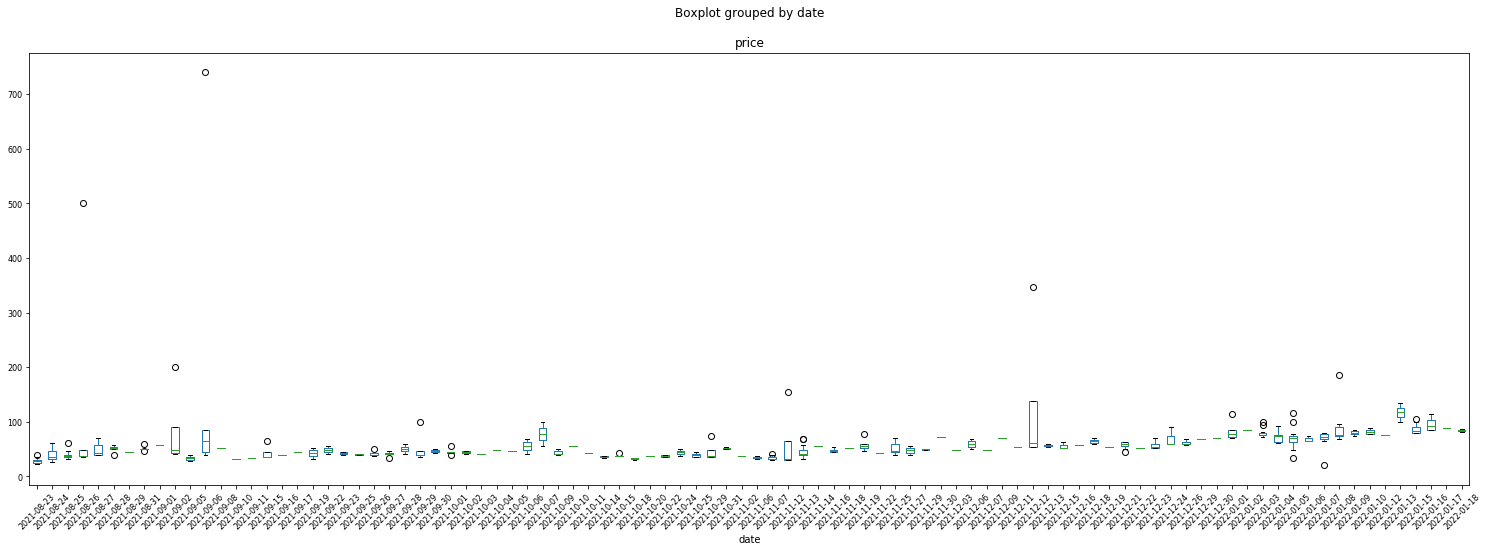

In [59]:
pdf.boxplot(grid=False, rot=45, fontsize=8, column=['price'], by='date', figsize=(25,8))
